<a href="https://colab.research.google.com/github/Asmaasa3d/Pose-Detection-project/blob/main/data_of_Pose_Detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks to:
- Amira Adel Foda
- Asmaa Said

From ITI Intake 42 Smart Village branch AI-Pro track Group 2

## All data to csv file

#### data download link  👇
http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip 

#### Anlges extraction is inspired from this repo
https://github.com/natanielruiz/deep-head-pose.git


In [ ]:
!unzip /content/drive/MyDrive/AFLW2000-3D.zip

In [ ]:
import numpy as np
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin
import dlib
import glob
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter

In [ ]:
mylist = [Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")]

In [ ]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines


In [ ]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

In [ ]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [ ]:
class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)

        # Crop the face loosely
        pt2d = get_pt2d_from_mat(mat_path)

        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]

        # if self.transform is not None:
        #     img = self.transform(img)
        # return cont_labels
        return img, labels, cont_labels, self.X_train[index]

    def __len__(self):
        # 2,000
        return self.length






In [ ]:
demo=AFLW2000("/content/AFLW2000/*.mat",'/content/AFLW2000/')

In [ ]:
features=[]
labels=[]
imgs=[]
for i in range(2000):
  features.append(demo.__getitem__(i)[1])
  x = np.array(demo.__getitem__(i)[2], dtype=np.float32)
  labels.append(x)
  imgs.append(demo.__getitem__(i)[3])



In [ ]:
print(imgs[0])
print(features[0])
print(labels[0])

image00002
[33 25 34]
[  1.044306  -22.874239    4.9088855]


In [ ]:
data = np.array(features, dtype=np.float32)

In [ ]:
labels = np.array(labels, dtype=np.float32)

In [ ]:
data1=np.concatenate((data,labels),axis=1)

In [ ]:

df = pd.DataFrame(data1,columns=['x','y','z','yaw', 'pitch', 'roll']) #convert to a dataframe


In [ ]:
df['img']=imgs

In [ ]:
df

,x,y,z,yaw,pitch,roll,img
0,33.0,25.0,34.0,1.044306,-22.874239,4.908885,image00002
1,55.0,41.0,38.0,68.155243,26.932743,17.243670,image00004
2,49.0,29.0,28.0,50.485413,-10.579652,-13.570645,image00006
3,38.0,29.0,25.0,17.143373,-10.048455,-21.392782,image00008
4,55.0,16.0,13.0,68.640549,-50.544582,-59.207973,image00010
...,...,...,...,...,...,...,...
1995,31.0,29.0,35.0,-4.035367,-11.293093,6.022806,image04358
1996,5.0,28.0,36.0,-81.288437,-13.327947,10.081747,image04363
1997,60.0,5.0,4.0,82.005562,-82.961685,-86.483292,image04364
1998,10.0,24.0,41.0,-68.249336,-24.090857,25.869925,image04365


In [ ]:
df.to_csv("testfile",index=False) #save to file

#Then, to reload:
df = pd.read_csv("testfile")

##Demo on one image

In [ ]:
def getitem(index,mat_path,image_mode='RGB'):
        ## index jpg inamge
        ##mat_path .mat image
        img = Image.open(index)
        img = img.convert(image_mode)
    
        # Crop the face loosely
        pt2d = get_pt2d_from_mat(mat_path)

        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]

        # if transform is not None:
        #     img = transform(img)

        return img, labels, cont_labels, index


In [ ]:
getitem('/content/AFLW2000/image00002.jpg','/content/AFLW2000/image00002.mat')

(<PIL.Image.Image image mode=RGB size=628x427 at 0x7F74B5043850>,
 array([33, 25, 34]),
 [1.044306042017331, -22.874238643575588, 4.908885557905314],
 '/content/AFLW2000/image00002.jpg')

## draw axis

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2022-05-04 23:43:08--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  64.9MB/s    in 0.9s    

2022-05-04 23:43:09 (64.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!wget http://arunponnusamy.com/files/mmod_human_face_detector.dat

In [ ]:
!bzip2 -d  '/content/shape_predictor_68_face_landmarks.dat.bz2'

In [ ]:
predictor=dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
cnn_face_detector = dlib.get_frontal_face_detector()


In [ ]:
# cv2.destroyAllWindows()
# model='/content/mmod_human_face_detector.dat'

# cnn_face_detector = dlib.cnn_face_detection_model_v1(model)
# image='/content/AFLW2000/image04153.jpg'
# frame = cv2.imread(image)

# cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

# dets = cnn_face_detector(cv2_frame, 1)
# for (idx, det) in enumerate(dets):
#             # Get x_min, y_min, x_max, y_max, conf
#             x_min = det.rect.left()
#             y_min = det.rect.top()
#             x_max = det.rect.right()
#             y_max = det.rect.bottom()
#             # conf = det.confidence
#             # print(det)
#             shape = predictor(cv2_frame, det.rect)
#             tdx,tdy=shape.part(33).x, shape.part(33).y
#             bbox_height, bbox_width = frame.shape[:2]
           
#             cv2.destroyAllWindows()
#             cv2_imshow(draw_axis(frame,-64,12 ,-10,tdx,tdy)
#             )
# cv2.destroyAllWindows()


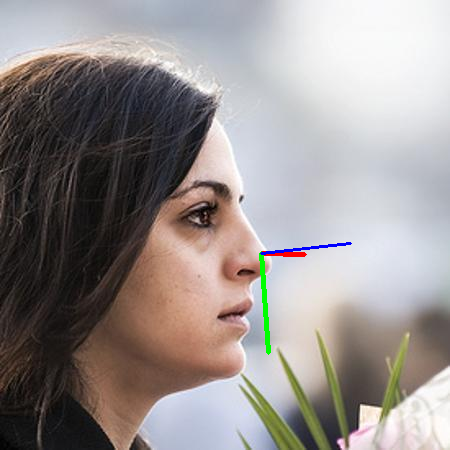

In [ ]:
image='/content/AFLW2000/image04153.jpg'
frame = cv2.imread(image)

cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

dets = cnn_face_detector(cv2_frame, 1)
for (idx, det) in enumerate(dets):
            # Get x_min, y_min, x_max, y_max, conf
            x_min = det.left()
            y_min = det.top()
            x_max = det.right()-x_min
            y_max = det.bottom()-y_min
            # conf = det.confidence
            # print(det)

            shape = predictor(cv2_frame, det)
            tdx,tdy=shape.part(30).x, shape.part(30).y
            bbox_height, bbox_width = frame.shape[:2]
           
            cv2.destroyAllWindows()
            cv2_imshow(draw_axis(frame,-64,12 ,-10,tdx,tdy)
            )
cv2.destroyAllWindows()
